# Error analysis

In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import tensorflow as tf
import shap
import h5py
import numpy as np
import pandas as pd
import os
import scipy.stats as ss
import src
from src.transfer_learn import KinnLayer, amber_app
from src.reload import reload_from_dir
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import defaultdict
from tqdm.notebook import tqdm
%matplotlib inline

Using TensorFlow backend.


In [3]:
if os.path.isdir("weights"):
    os.rmdir("weights")
amb = amber_app(wd=".", run=False)
# clean up folders created by trainEnv
os.rmdir("weights")

BUILDING
----------


2023-08-21 20:17:33,143 - AMBER - INFO -
 time budget set to: 72:00:00


controller = GeneralController
modeler = <class 'src.transfer_learn.TransferKinnModelBuilder'>
knowledge = zero
reward = LossAucReward
manager = GeneralManager
env_type = ControllerTrainEnv


In [4]:
# I'll make this hard-coded for now for faster reproducibility
# for how this table is generated, see `11-TL_model_analysis-Valid_v_Test.ipynb`
benchmark_df = pd.read_table("./outputs/analysis/transfer_learn.incremental_benchmark.tsv")
benchmark_df

,Kleinsitver,Listgarten,Listgarten_Indel,Valid,step,n_models,indv_perform,arc,trial,wd
0,0.188933,0.140707,0.208201,0.437008,0,1,"[0.189, 0.141, 0.208]","[0, 1, 5, 0, 0, 0, 1]",480,outputs/2022-11-01/TL_5
1,0.324715,0.195480,0.278344,0.439494,1,2,"[0.287, 0.188, 0.304]","[0, 2, 5, 0, 0, 0, 5]",494,outputs/2022-11-01/TL_3
2,0.316479,0.228706,0.352824,0.442244,2,3,"[0.242, 0.122, 0.247]","[1, 1, 5, 1, 1, 0, 5]",484,outputs/2022-11-01/TL_2
3,0.325627,0.222703,0.301412,0.442706,3,4,"[0.225, 0.127, 0.146]","[1, 2, 5, 0, 1, 0, 1]",494,outputs/2022-11-01/TL_1
4,0.364205,0.261566,0.324285,0.445176,4,5,"[0.186, 0.119, 0.171]","[0, 1, 1, 2, 1, 0, 3]",481,outputs/2022-11-01/TL_4


In [5]:
# load models
model_ensemble = []
for _, row in tqdm(benchmark_df.iterrows(), total=len(benchmark_df)):
    arc_seq = eval(row['arc'])
    target_wd = row['wd']
    best_trial_id = row['trial'] 
    #print(type(arc_seq))
    model = amb.model_fn(arc_seq)
    model.load_weights(os.path.join(target_wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))
    model_ensemble.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
# load data
with h5py.File("./data/inVivoData.newValidSplit.h5", "r") as store:
    t1 = store["test/Kleinsitver_mut/x"][()], store["test/Kleinsitver_mut/y"][()]
    t2 = store["test/Listgarten_mut/x"][()], store["test/Listgarten_mut/y"][()]
    t3 = store["test/Listgarten_indel/x"][()], store["test/Listgarten_indel/y"][()]
    valid_data = store["valid/x"][()], store["valid/y"][()]
    kin_data = store["kinetic/x"][()], store["kinetic/y"][()], store["kinetic/k"][()]

data_cache = {
    'kleinsitver': t1,
    'listgarten': t2,
    'listgarten_indel': t3,
    'valid': valid_data,
    'kinetic': kin_data
}

In [7]:
# get baseline AUPR for revised MS
for data_id in data_cache:
    print(data_id, data_cache[data_id][1].mean())

kleinsitver 0.0005635037410387252
listgarten 0.00014603755773047203
listgarten_indel 0.0002804485306834063
valid 0.012045201926639496
kinetic 0.4985349817766026


In [7]:
def get_base_kinn_model(model):
    layer_dict = {l.name:l for l in model.layers}
    k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
    seq_ohe = model.inputs[0]
    seq_ohe = tf.gather(seq_ohe, layer_dict[k_layer_name].channels, axis=-1)
    inp_list = layer_dict[k_layer_name].mb.blockify_seq_ohe(seq_ohe)
    kinn_rates = layer_dict[k_layer_name].kinn_header(inp_list)
    clv = layer_dict[k_layer_name].kinn_body(kinn_rates)
    kinetic_model = tf.keras.models.Model(
        inputs = model.inputs,
        outputs = clv
    )
    return kinetic_model

def get_shap(model, kinn, x):
    bg_seq = np.zeros((1,25,13))
    e=shap.GradientExplainer(model, bg_seq, batch_size=25000)
    e2=shap.GradientExplainer(kinn, bg_seq, batch_size=25000)
    res = e.shap_values(X=x)
    res2 = e2.shap_values(X=x)
    diff = (res[0]/np.abs(res[0]).max()-res2[0]/np.abs(res2[0]).max()).squeeze().T
    diff = diff/np.abs(diff).max()
    return res[0], res2[0], diff


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib import colors


def mat_to_seq(annot):
    letters = list('ACGT')
    seq_ohe = annot[:, 0:4]
    s = [letters[np.where(x)[0][0]] if np.sum(x)==1 else 'N' for x in seq_ohe]
    return s


def heatmap_with_circle(s, c, annot, remove_indel=True):
    N = 13 if remove_indel is False else 8
    M = 25
    letters = 'ACGT'
    ylabels = list(letters) + ['s-%s'%x for x in letters]
    if remove_indel: 
        s = s[0:8]
        c = c[0:8]
    else:
        ylabels +=  ['i-%s'%x for x in letters] + ['d']
    #xlabels = np.arange(1, M+1)
    xlabels = mat_to_seq(annot)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    #s = np.random.randint(0, 180, size=(N,M))
    #c = np.random.rand(N, M)-0.5

    fig, ax = plt.subplots(1,1,figsize=(12,5))

    R = s/s.max()/2
    circles = [plt.Circle((j,i), radius=r, alpha=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
    rdgn = sns.diverging_palette(h_neg=220, h_pos=0, s=99, l=70, sep=10, n=10, as_cmap=True)
    divnorm=colors.TwoSlopeNorm(vmin=-0.5, vcenter=0., vmax=0.5)
    col = PatchCollection(circles, array=c.flatten(), cmap=rdgn, norm=divnorm)
    ax.add_collection(col)

    ax.set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.grid(which='minor')

    fig.colorbar(col)
    plt.gca().invert_yaxis()
    return fig, ax

In [9]:
with open("./outputs/analysis/transfer_learning.model_intermediate.pkl", "rb") as f:
    res = pickle.load(f)


In [10]:
data_id = 'kleinsitver'
in_vitro_clv = []
in_vivo_clv = []
for model_id in range(5):
    tmp = res[(model_id, data_id)]
    in_vitro_clv.append(tmp['old_clv'])
    in_vivo_clv.append(tmp['new_clv'])
df = pd.DataFrame({
    'in_vitro_clv': np.array(in_vitro_clv).mean(axis=0), 
    'in_vivo_clv': np.array(in_vivo_clv).mean(axis=0)})
df['label'] = data_cache[data_id][1]

In [11]:
from sklearn.metrics import average_precision_score
average_precision_score(df['label'], df['in_vivo_clv'])

0.3616882263629

In [12]:
n_top = 3
fn_vivo = df.query('label==1').sort_values('in_vivo_clv').head(n_top)
fn_vitro = df.query('label==1').sort_values('in_vitro_clv').head(n_top)
# 15345 and 16128 etc. are in fact on-target sequences with label=0
fp_vivo = df[df.index!=16128].query('label==0').sort_values('in_vivo_clv').tail(n_top)
fp_vitro = df.drop([15345,16128,42258,28338,52282]).query('label==0').sort_values('in_vitro_clv').tail(n_top)


In [13]:
from collections import defaultdict
fn_vivo_res = defaultdict(list)
fp_vivo_res = defaultdict(list)
fn_vitro_res = defaultdict(list)
fp_vitro_res = defaultdict(list)

for model_id in tqdm(range(len(model_ensemble))):
    model = model_ensemble[model_id]
    kinn = get_base_kinn_model(model)

    # fn_vivo
    for idx in fn_vivo.index:
        if os.path.isfile("./outputs/analysis/revision/fn_vivo_{data_id}_{idx}.png"):
            continue
        #print(idx)
        x=data_cache[data_id][0][[idx]]
        res, res2, diff = get_shap(model, kinn, x)
        fn_vivo_res[idx].append(res)
    
    # fp_vivo
    for idx in fp_vivo.index:
        if os.path.isfile("./outputs/analysis/revision/fp_vivo_{data_id}_{idx}.png"):
            continue
        #print(idx)    
        shaps = []
        x=data_cache[data_id][0][[idx]]
        res, res2, diff = get_shap(model, kinn, x)
        fp_vivo_res[idx].append(res)

    # fn_vitro
    for idx in fn_vitro.index:
        if os.path.isfile("./outputs/analysis/revision/fn_vitro_{data_id}_{idx}.png"):
            continue
        #print(idx)
        x = data_cache[data_id][0][[idx]]
        res, res2, diff = get_shap(model, kinn, x)
        fn_vitro_res[idx].append(res2)

    # fp_vitro
    for idx in fp_vitro.index:
        if os.path.isfile("./outputs/analysis/revision/fp_vitro_{data_id}_{idx}.png"):
            continue        
        #print(idx)
        x = data_cache[data_id][0][[idx]]
        res, res2, diff = get_shap(model, kinn, x)
        fp_vitro_res[idx].append(res2)    
    

  0%|          | 0/5 [00:00<?, ?it/s]

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


false negative in vivo
false positive in vivo
false negative in vitro
false positive in vitro


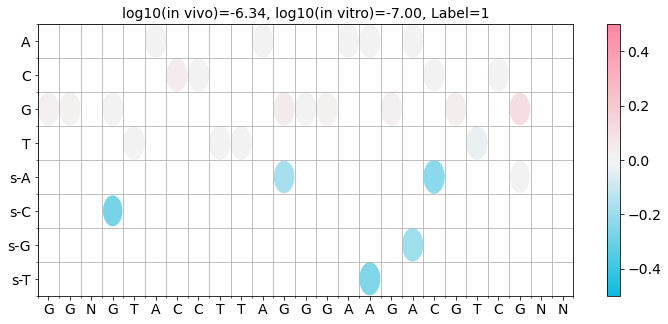

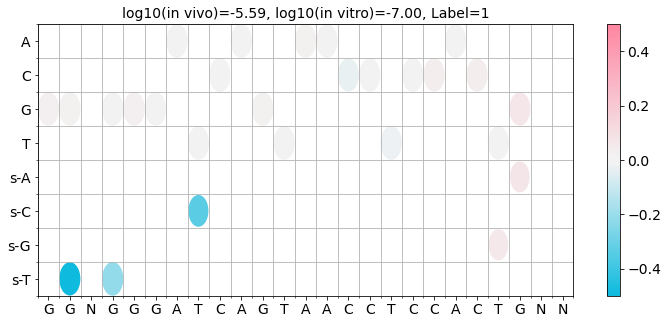

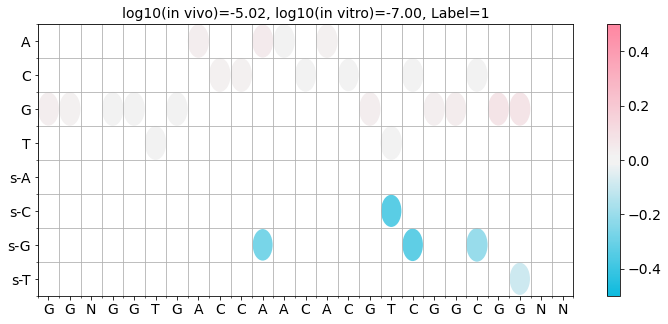

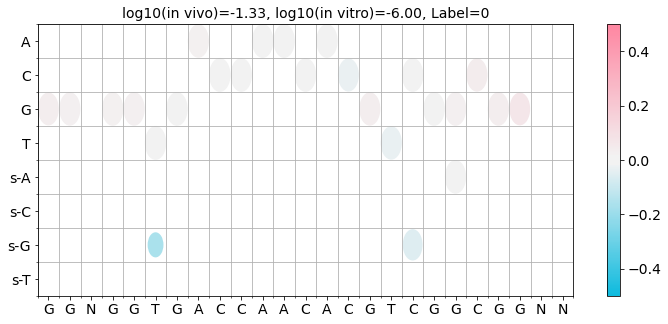

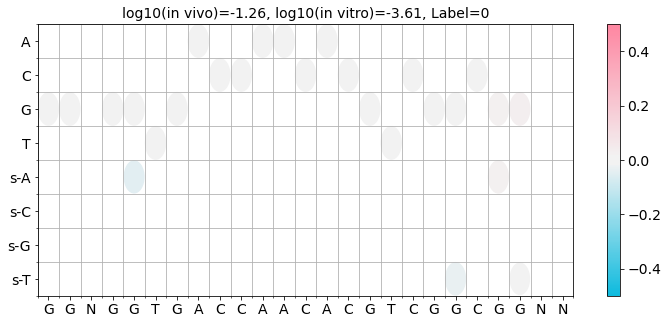

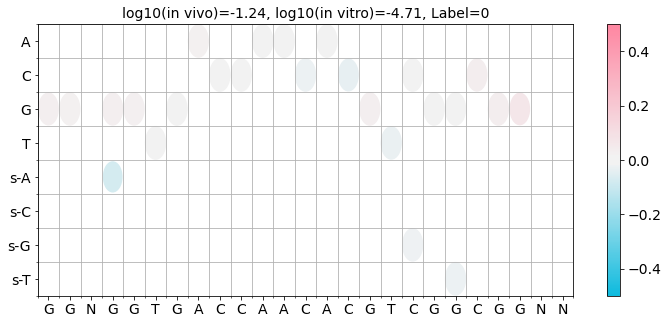

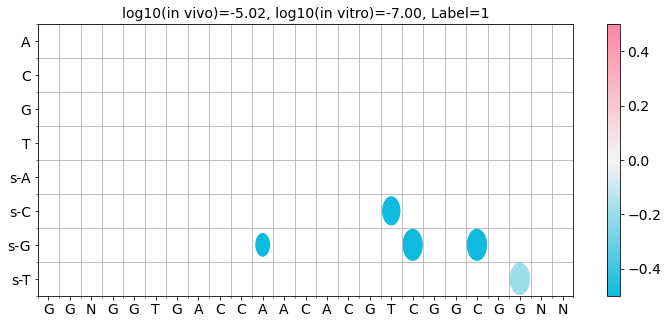

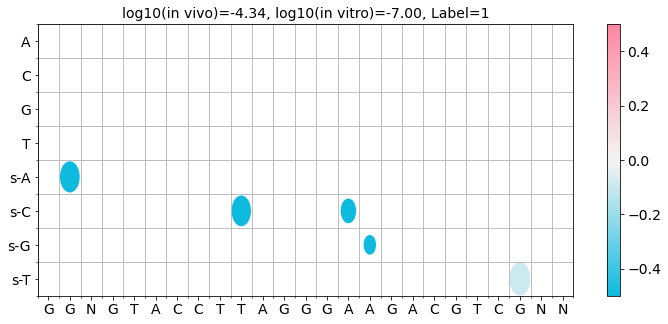

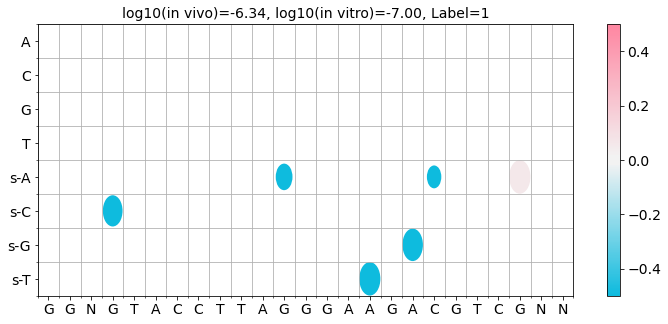

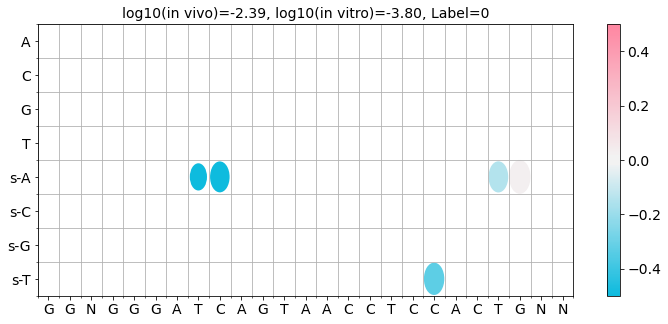

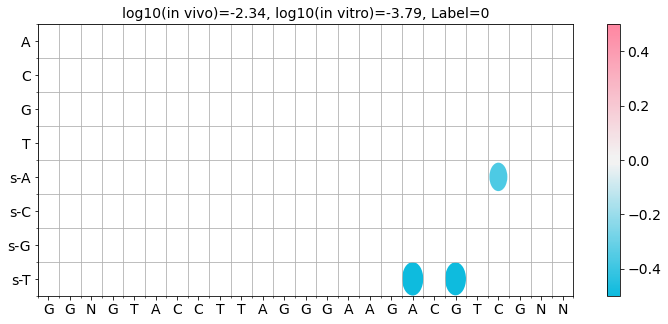

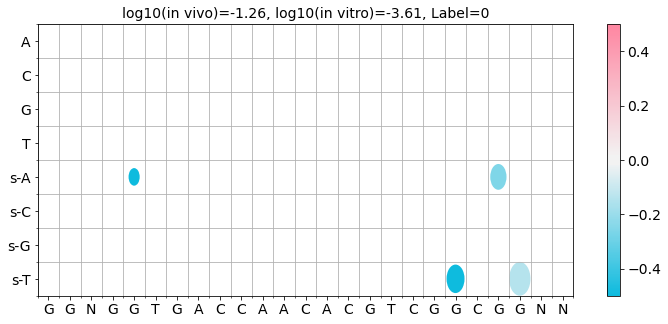

In [14]:
def make_plot(result_list, clv_df, save_fn):
    shaps = np.array(result_list).squeeze()
    c = shaps.mean(axis=0, keepdims=False).copy()
    c[c==0] = np.nan
    s = (1/(shaps.var(axis=0, keepdims=False)+0.1))
    annot = data_cache[data_id][0][idx]
    fig, ax = heatmap_with_circle(c=c.T, s=s.T, annot=annot, remove_indel=True)
    ax.set_title("log10(in vivo)=%.2f, log10(in vitro)=%.2f, Label=%i" % (
        clv_df.loc[idx, 'in_vivo_clv'], 
        clv_df.loc[idx, 'in_vitro_clv'],
        clv_df.loc[idx, 'label'],
    ))
    fig.savefig(save_fn)
    return fig

print('false negative in vivo')
for idx in fn_vivo_res:
    make_plot(
        result_list=fn_vivo_res[idx], 
        clv_df=fn_vivo, 
        save_fn=f"./outputs/analysis/revision/fn_vivo_{data_id}_{idx}.png"
    )
    
print('false positive in vivo')
for idx in fp_vivo_res:
    if not len(fp_vivo_res[idx]): continue
    make_plot(
        result_list=fp_vivo_res[idx], 
        clv_df=fp_vivo, 
        save_fn=f"./outputs/analysis/revision/fp_vivo_{data_id}_{idx}.png"
    )

print('false negative in vitro')
for idx in fn_vitro_res:
    make_plot(
        result_list=fn_vitro_res[idx], 
        clv_df=fn_vitro, 
        save_fn=f"./outputs/analysis/revision/fn_vitro_{data_id}_{idx}.png"
    )

print('false positive in vitro')
for idx in fp_vitro_res:
    if not len(fp_vitro_res[idx]): continue
    make_plot(
        result_list=fp_vitro_res[idx], 
        clv_df=fp_vitro, 
        save_fn=f"./outputs/analysis/revision/fp_vitro_{data_id}_{idx}.png"
    )

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w


Last updated: Fri Aug 18 2023

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

seaborn   : 0.11.1
shap      : 0.41.0
src       : 0.0.3
pandas    : 1.0.3
matplotlib: 3.4.3
numpy     : 1.19.5
scipy     : 1.7.3
h5py      : 2.10.0
tensorflow: 1.15.0

Watermark: 2.3.1

